In [0]:
%matplotlib inline

import sys
import math
import statsmodels as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [0]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("statsmodels", ss.__version__),
            ("pandas", pd.__version__),
           ("keras", keras.__version__) )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

In [0]:
# fix random seed for reproducibility
np.random.seed(0)

In [0]:
# load the dataset
df = pd.read_csv('co2-ppm-mauna-loa-19651980.csv', usecols=[1], engine='python', skipfooter=3)
data = df.values
data = data.astype('float32')
print('Number of datapoints:',len(data))

Number of datapoints: 192


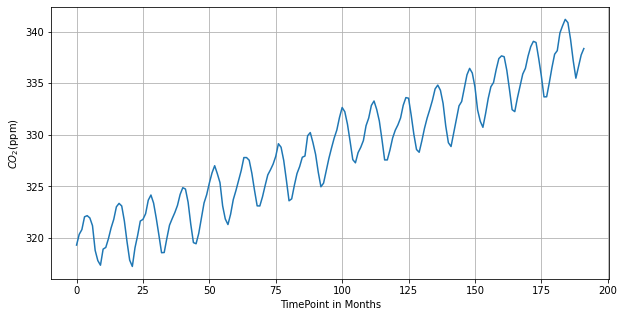

In [0]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in Months')
plt.ylabel('$CO_2$(ppm)')
plt.grid()
plt.plot(data);

In [0]:
# split into train and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print('Train Set contains:', len(train),'data points')
print('Test Set contains:', len(test),'data points')

Train Set contains: 128 data points
Test Set contains: 64 data points


### Normalizing Dataset

We need to normalize the dataset to bring the scale down to 0 - 1 to make RNN and LSTM prediction easier

In [0]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
norm_train = scaler.fit_transform(train)
norm_test = scaler.transform(test)

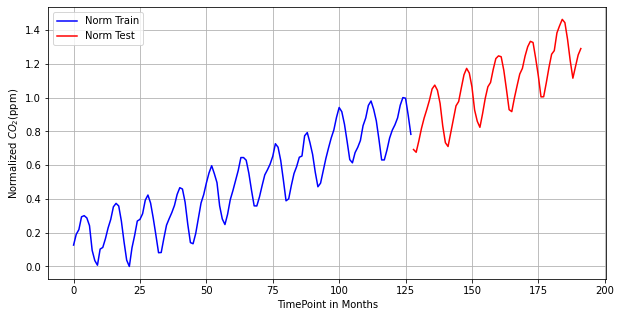

In [0]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in Months')
plt.ylabel('Normalized $CO_2$(ppm)')
plt.grid()
plt.plot(range(len(train)),norm_train,'b')
plt.plot(range(len(train),len(train)+len(test)),norm_test,'r')
plt.legend(['Norm Train','Norm Test']);

Splitting the data into X and y - where X is the input vector of values used to predict y. X contains one value by default (the previous value), we can add more by using higher values of look_back to possibly predict better.

In [0]:
def split_X_y(data, look_back = 1):
    X, y = [], []
    for i in range(len(data)-look_back):
        val = data[i:i+look_back,0]
        X.append(val)
        y.append(data[i+look_back:i+look_back+1,0])
    return np.array(X), np.array(y)

In [0]:
# reshape into X contains the data for times t-i ... t-2 t-1 and Y contains the data for times t
look_back = 1 # here we will only look at the previous datapoint to predict the next one
trainX, trainY = split_X_y(norm_train, look_back)
testX, testY = split_X_y(norm_test, look_back)

In [0]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(127, 1)
(127, 1)
(63, 1)
(63, 1)


In [0]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [0]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(127, 1, 1)
(127, 1)
(63, 1, 1)
(63, 1)


### Simple RNN

In [0]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],look_back)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=1, verbose=2)
    
    return model

In [0]:
# This might take a while
model = fit_SimpleRNN(trainX, trainY, cell_units=256, epochs=500)

Making predictions of trained model and transforming them back to the original scale.

In [0]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainYTrue = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testYTrue = scaler.inverse_transform(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYTrue, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYTrue, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Plotting to look at the results.

In [0]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in Months')
plt.ylabel('$CO_2$(ppm)')
plt.grid()
plt.plot(range(len(data)),data,'k.')
plt.plot(range(look_back,len(trainPredict)+look_back),trainPredict,'b')
plt.plot(range(len(trainPredict)+look_back,len(trainPredict)+len(testPredict)+look_back),testPredict,'r')
plt.legend(['Actual','Train','Test']);

### LSTM

In [0]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct an LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],look_back)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=1, verbose=2)
    
    return model

In [0]:
# This might take a while
model = fit_LSTM(trainX, trainY, cell_units=64, epochs=100)

Epoch 1/100
 - 1s - loss: 0.1316
Epoch 2/100
 - 0s - loss: 0.0269
Epoch 3/100
 - 0s - loss: 0.0187
Epoch 4/100
 - 0s - loss: 0.0119
Epoch 5/100
 - 0s - loss: 0.0084
Epoch 6/100
 - 0s - loss: 0.0063
Epoch 7/100
 - 0s - loss: 0.0052
Epoch 8/100
 - 0s - loss: 0.0053
Epoch 9/100
 - 0s - loss: 0.0053
Epoch 10/100
 - 0s - loss: 0.0052
Epoch 11/100
 - 0s - loss: 0.0052
Epoch 12/100
 - 0s - loss: 0.0052
Epoch 13/100
 - 0s - loss: 0.0048
Epoch 14/100
 - 0s - loss: 0.0049
Epoch 15/100
 - 0s - loss: 0.0054
Epoch 16/100
 - 0s - loss: 0.0053
Epoch 17/100
 - 0s - loss: 0.0049
Epoch 18/100
 - 0s - loss: 0.0055
Epoch 19/100
 - 0s - loss: 0.0051
Epoch 20/100
 - 0s - loss: 0.0052
Epoch 21/100
 - 0s - loss: 0.0050
Epoch 22/100
 - 0s - loss: 0.0053
Epoch 23/100
 - 0s - loss: 0.0051
Epoch 24/100
 - 0s - loss: 0.0050
Epoch 25/100
 - 0s - loss: 0.0054
Epoch 26/100
 - 0s - loss: 0.0052
Epoch 27/100
 - 0s - loss: 0.0052
Epoch 28/100
 - 0s - loss: 0.0051
Epoch 29/100
 - 0s - loss: 0.0053
Epoch 30/100
 - 0s - lo

In [0]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainYTrue = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testYTrue = scaler.inverse_transform(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYTrue, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYTrue, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.12 RMSE
Test Score: 1.20 RMSE


We can see how LSTM's have comparable accuracy even though it has lesser number of units and iterations. This is because LSTM's have a more complex cell structure, making them able to generalize better with longer memory than RNN's.

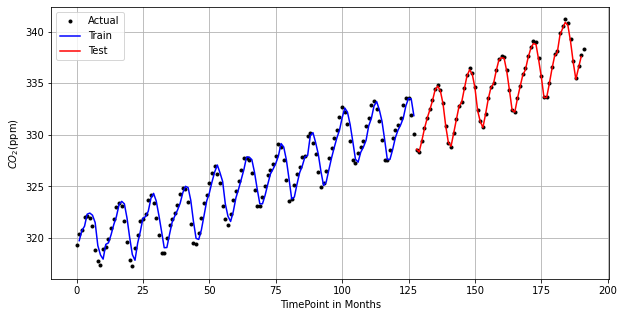

In [0]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in Months')
plt.ylabel('$CO_2$(ppm)')
plt.grid()
plt.plot(range(len(data)),data,'k.')
plt.plot(range(look_back,len(trainPredict)+look_back),trainPredict,'b')
plt.plot(range(len(trainPredict)+look_back,len(trainPredict)+len(testPredict)+look_back),testPredict,'r')
plt.legend(['Actual','Train','Test']);

That's the end of this hands-on session! Please feel free to experiment with this notebook as necessary to see the results.